## Lista 1 - Disciplina IA006 - Exercícios de Fixação 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
class MyData():
    """MyData facilitates manipulation of time series data
    
    This class loads a time series and build features from delayed
    versions of the input data. Also, there is a method for automatically
    spliting data into k-folds.
    """
    
    def __init__(self, array):
        self.years = array[:, 0].copy()
        self.sunspot = array[:, 1:].copy()
        
        # create 20 features which are delays of the original data
        # and remove rows that contains zeros as input features
        flat_sunspot = self.sunspot.flatten()
        data = np.zeros( (flat_sunspot.shape[0], 21) )
        data[:,-1] = flat_sunspot
        for i in range(20):
            data[(i+1):, i] = flat_sunspot[:-(i+1)]
        self.data = data[20:] #drop first 20 lines because of zero'd features
        
        self.features = self.data[:, :-1]
        self.label = self.data[:, -1]
        self.nfeatures = self.features.shape[1]
        self.nrows = self.features.shape[0]
        
    def split_kfold(self, bins, nktest):
        assert (nktest < bins), "Fold selected for test must be within number of K-folds"
        
        nrows = self.nrows
        nelements = np.ceil(nrows/bins)
        
        # mask is True for Test rows and False for Train rows
        mask = np.array([ True if ((i >= nelements*nktest) and (i < nelements*(nktest+1))) 
                          else False 
                          for i in range(nrows)],
                        dtype='bool')

        features_train = self.features[~mask]
        label_train = self.label[~mask]
        features_test = self.features[mask]
        label_test = self.label[mask]
        
        return features_train, label_train, features_test, label_test         

In [4]:
class LinearRegressor():
    """LinearRegressor instances hold a Ridge Linear Regressor
    
    Class of a ridge linear regression model, with methods for fitting
    the model, transforming new data and assessment of model performance.
    """
    
    def __init__(self):
        self.w = None
        self.nfeatures = None
        
    def fit(self, features, label, lamb=0):
        assert (lamb >= 0), "Regularization should be non-negative number."
        
        self.nfeatures = features.shape[1]
        nlines = features.shape[0]
        # first column will be the constant bias
        fea = np.hstack( ( np.ones((nlines,1)), features ) )       
        
        if lamb == 0:
            self.w = np.linalg.inv( fea.T @ fea ) @ fea.T @ label
        if lamb  > 0:
            pseudo_eye = np.eye(fea.shape[1])
            pseudo_eye[0, 0] = 0
            self.w = np.linalg.inv( (fea.T @ fea) + (pseudo_eye * lamb) ) @ fea.T @ label
        return self
    
    def transform(self, x):
        assert (self.w is not None), "Transformer was not trained yet."
        assert (x.shape[1] == self.nfeatures), "Input error: wrong number of columns"
            
        fea = np.zeros( (x.shape[0], x.shape[1] + 1) )
        fea[:, 0] = 1
        fea[:, 1:] = x
        return fea @ self.w
    
    def eval_mse(self, features, label):
        label_pred = self.transform(features)
        return self.mse(label, label_pred)
        
    def mse(self, y_real, y_pred):
        return np.mean(np.square(y_real - y_pred))

In [5]:
class BoolMask():
    """BoolMask is a class for manipulation of boolean masks
    
    This class helps manipulation of boolean masks, aiming at
    numpy array advanced indexing.
    """
    
    def __init__(self, nfeatures=20, mask=None):
        if (mask is not None):
            self.mask = mask.copy()
        else:
            self.mask = np.ones(nfeatures, dtype='bool')
        
    def clearFea(self, feature):
        self.mask[feature] = False
    
    def setFea(self, feature):
        self.mask[feature] = True
        
    def getFea(self, feature):
        return self.mask[feature]
        
    def copy(self):
        r = BoolMask(mask=self.mask)
        return r

In [6]:
## Auxiliar functions
def plot_dual(y_real, y_prediction, title=None, lab1=None, lab2=None):
    if lab1 is None:
        lab1 = 'Série real'
    if lab2 is None:
        lab2 = 'Série estimada'
    
    plt.plot(y_real, label=lab1)
    plt.plot(y_prediction, label=lab2)

    plt.legend()
    plt.xlabel('Meses')
    plt.ylabel('Sunspot')
    if (title != None):
        plt.title(title)
    
    plt.show()
    return

def p_correlation(x, y):
    xm = x - x.mean()
    ym = y - y.mean()
    
    return (xm.dot(ym))/np.sqrt(xm.dot(xm)*ym.dot(ym))

## Preparação para os exercícios
Nessa etapa, os dados de entrada foram carregados a partir do arquivo de entradas `sunspot.txt`. Este arquivo contém a série histórica de medidas do número de manchas solares. Temos a disposição leituras mensais desde 1749 até 2014, o que equivalem a 3192 observações

A classe `MyData` foi utilizada para manipular os dados de entrada. Ela é responsável por transformar a série temporal em dois conjuntos de dados: um vetor de valores esperados para o `i-ésimo` instante e uma matriz de features, onde cada linha corresponde aos features do *i-ésimo* instante, e cada feature é composta por observações passadas (coluna `0` é o instante `i-1`, coluna `1` é o instante `i-2`, etc).

In [7]:
DEBUG = False

fname = '../data/sunspot.txt'
data = np.loadtxt(fname)
dt = MyData(data)

print("Número de observações do nosso conjunto de dados: ", dt.nrows)
print("Número de features: ", dt.nfeatures)

Número de observações do nosso conjunto de dados:  3172
Número de features:  20


Interessante notar que o número de observações é menor que o esperado. As primeiras 20 observações foram eliminadas pois a ausência de observações passadas poderiam intefirir na regressão linear.

### Exercício 1.a)

Um regressor linear foi construído utilizando *quadrados mínimos irrestrito* como função custo do modelo. O conjunto foi dividido em treino e teste, de forma que os ultimos 5 anos de observações (equivalente à 60 meses) foram teste, e o restante, treino. Este modelo não utiiza regularização.

Erro quadrático médio para dados de treinamento:  15.370232088543426
Erro quadrático médio para dados de teste:  14.24945111274465


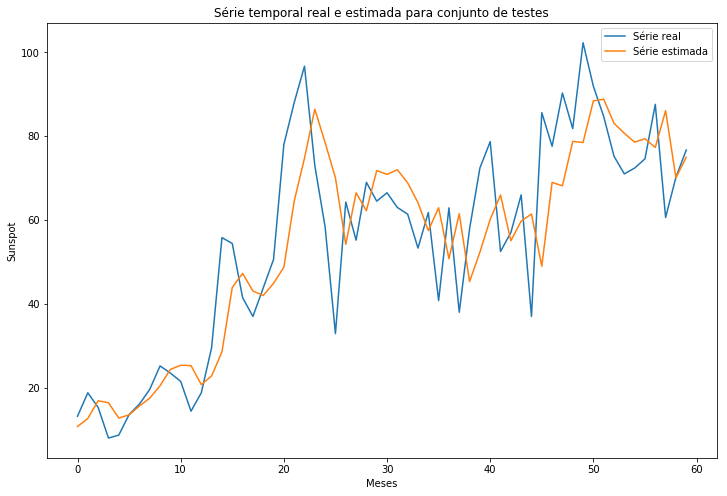

In [8]:
model = LinearRegressor()
testLen = 60

test_features  = dt.features[-testLen:]
train_features = dt.features[:-testLen]
test_label     = dt.label[-testLen:]
train_label    = dt.label[:-testLen]

model.fit(train_features, train_label, lamb=0)
train_pred = model.transform(train_features)
test_pred = model.transform(test_features)

print("Erro quadrático médio para dados de treinamento: ", np.sqrt(model.mse(train_label, train_pred)))
print("Erro quadrático médio para dados de teste: ", np.sqrt(model.mse(test_label, test_pred)))

plot_dual(test_label, test_pred, "Série temporal real e estimada para conjunto de testes")

Os erros (erro quadrático médio) de treinamento e teste foram, respectivamente, `15.37` e `14.25`. Em geral, utilizando-se a técnica de *Holdout* o erro do conjunto de testes tende a ser maior que o erro do arquivo de treino. Entretanto, situações onde o conjunto de teste não contempla toda a variabilidade do conjunto de treino (por exemplo, um desbalanceamento de classes em um problema de classificação), a situação pode se inverter. Isso é um indicativo de que técnicas como *K-Fold Validation* poderiam beneficiar a análise.

A figura acima apresenta a série temporal real e a estimativa do modelo linear para o conjunto de dados de teste. É interessante notar que a série estimada acompanha a série real, o que sugere que nosso modelo linear está correto, porém com um atraso de 1 mês. Esta característica sugere que o poder de predição do nosso modelo se limita a prever o próximo valor da série como o valor do mês anterior.

Essa característica fica clara ao adiantar-se de forma sintética a série estima:

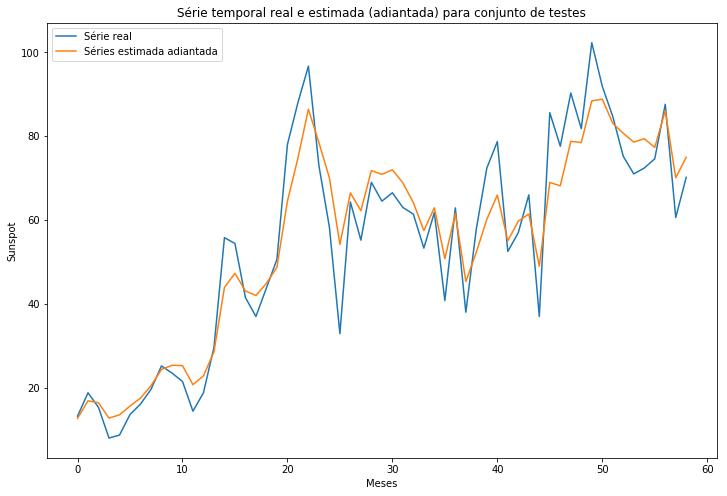

In [9]:
plot_dual(test_label[:-1], test_pred[1:], "Série temporal real e estimada (adiantada) para conjunto de testes",
          "Série real", "Séries estimada adiantada")

Esse comportamento não se trata de um erro na execução da regressão linear, e sim de uma dificuldade inerente à series temporais, pois a unica informação que o modelo construído tem acesso é de instantes de tempos passados da série de interesse.

### Exercício 1.b)
Agora, vamos considerar a aplicação da estratégia de seleção de variáveis
denominada wrapper, seguindo a abordagem backward elimination. Ademais,
a fim de medirmos de forma mais robusta o desempenho de cada subconjunto
de variáveis de entrada, vamos utilizar um esquema de validação cruzada do
tipo -fold. Por fim, vamos também considerar a técnica ridge regression
para a regularização do modelo.

Nesta etapa, empregou-se a técnica de wrapper, seguindo a abordagem backward elimination, para redução de features. Além disso, a medida de desempenho foi feita utilizando-se o esquema de validação cruzada K-fold, que é um método mais robusto que Holdout. Por fim, a regressão linear foi modificada para aceitar um parâmetro *lambda* de regularização. Para cada conjunto de features, testaram-se diferentes valores de lambda dentro do range de `1,5^-1` até `1,5^30`.

In [10]:
def kfold_loop(featureMask, data, nFolds):
    mse = 0
    for k in range(nFolds):
        # k-fold loop
        features_train, label_train, features_test, label_test = data.split_kfold(nFolds, k)
        model = LinearRegressor()
        model.fit(features_train[:, featureMask], label_train, lamb=lamb)
        mse += model.eval_mse(features_test[:, featureMask], label_test)
    mse /= nFolds
    return np.sqrt(mse)

# Defining boolMask for features
kfNum = 10 # Number of folds
ridgeList = np.array([1.5**k for k in range(-1, 30)]) # List of lambdas to be tested
mask = BoolMask(20) # Boolean mask for removing features (columns)
wrapperResult = [] # Array to store results
for wrap in range(0, dt.nfeatures - 1): 
    bestRmse = np.inf
    bestLamb = None
    bestMask = None
    for fea in range(dt.nfeatures):
        if mask.getFea(fea):
            mask.clearFea(fea)
            if (DEBUG): print("Mask: ", mask.mask)
            for lamb in ridgeList:
                currRmse = kfold_loop(mask.mask, dt, kfNum) 
                if (DEBUG): print('kfold rmse: {}, Wrapper #: {}, Feat. removida: {}, lambda: {:<7.10f}'
                        .format(currRmse, wrap, fea, lamb))
                if currRmse < bestRmse:
                    if (DEBUG): print('currRmse: {}, bestRmse: {}'.format(currRmse, bestRmse))
                    bestRmse = currRmse
                    bestLamb = lamb
                    bestMask = mask.copy()
            mask.setFea(fea)
    wrapperResult.append({'RMSE': bestRmse, 'Lambda': bestLamb,'Features': bestMask.mask, 'nFeatures': bestMask.mask.sum()})
    mask = bestMask

In [11]:
for r in wrapperResult:
    print("Utilizando {} features, RMSE: {:.6f}, Lambda: {:0.3f}".
          format(r['nFeatures'], r['RMSE'], r['Lambda']))

Utilizando 19 features, RMSE: 15.480697, Lambda: 25251.168
Utilizando 18 features, RMSE: 15.472540, Lambda: 16834.112
Utilizando 17 features, RMSE: 15.465159, Lambda: 16834.112
Utilizando 16 features, RMSE: 15.459764, Lambda: 11222.741
Utilizando 15 features, RMSE: 15.455037, Lambda: 7481.828
Utilizando 14 features, RMSE: 15.450774, Lambda: 7481.828
Utilizando 13 features, RMSE: 15.447004, Lambda: 7481.828
Utilizando 12 features, RMSE: 15.445427, Lambda: 4987.885
Utilizando 11 features, RMSE: 15.447066, Lambda: 4987.885
Utilizando 10 features, RMSE: 15.450033, Lambda: 3325.257
Utilizando 9 features, RMSE: 15.455627, Lambda: 3325.257
Utilizando 8 features, RMSE: 15.460256, Lambda: 2216.838
Utilizando 7 features, RMSE: 15.488687, Lambda: 985.261
Utilizando 6 features, RMSE: 15.539915, Lambda: 86.498
Utilizando 5 features, RMSE: 15.603440, Lambda: 0.667
Utilizando 4 features, RMSE: 15.779084, Lambda: 0.667
Utilizando 3 features, RMSE: 16.041819, Lambda: 0.667
Utilizando 2 features, RMSE: 

Acima temos o resultado do experimento. Para cada conjunto de features ótimo descoberto pelo wrapper, temos o respectivo número de features, o erro quadrático médio (RMSE) e o valor de Lambda utilizado na regularização.
Observamos que o número ótimo de features encontrado foi de 12, com um valor de erro quadrático médio de `15.445427` e o valor lambda de `4987.885`. 

O melhor conjunto de features, compreendendo 12 features, foi:  [1, 2, 3, 4, 5, 6, 8, 9, 11, 16, 18, 20]


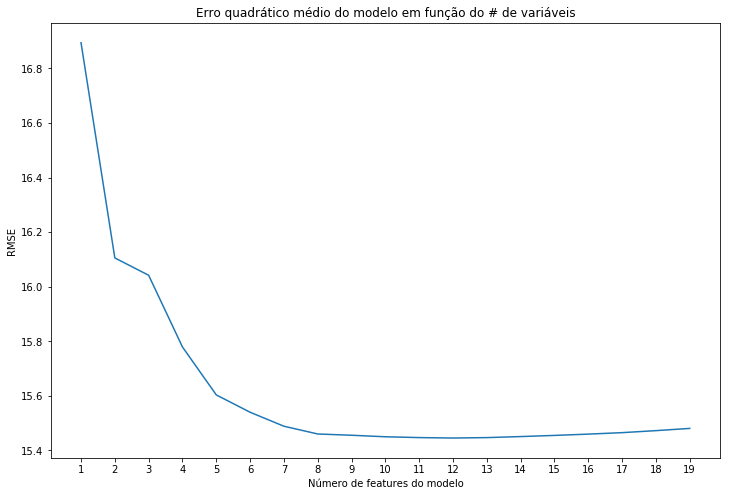

In [12]:
RMSE = np.zeros(dt.nfeatures-1)
nFeatures = []
features = []
for i, r in enumerate(wrapperResult):
    RMSE[i] = r['RMSE']
    nFeatures.append(int(r['nFeatures']))
    features.append(r['Features'])
    
plt.plot(nFeatures, RMSE)
plt.xticks(nFeatures)
plt.xlabel("Número de features do modelo")
plt.ylabel("RMSE")
plt.title("Erro quadrático médio do modelo em função do # de variáveis")

bestFeat = features[RMSE.argmin()]

f=[]
for i, flag in enumerate(bestFeat):
    if (flag):
        f.append(i+1)
print("O melhor conjunto de features, compreendendo 12 features, foi: ",f)

Acima temos a curva formada entre o número de features utilizada pelo modelo e o correspondente RMSE. Observa-se que o conjunto ótimo contém 12 features. Essas 12 features ótimas são formadas pelo seguinte conjunto de atrasos: 1, 2, 3, 4, 5, 6, 8, 9, 11, 16, 18 e 20.

### Exercício 1.c)

Utilizaremos agora a técnica denominada filtro para encontrar o conjunto ideal de features. O critério utilizado foi a correlação de Pearson. Tendo em vista obter o mesmo conjunto de features do item anterior, o *threhold* do filtro foi definido como o valor para o qual 12 features fossem selecionadas.

In [13]:
corr = np.array([p_correlation(dt.features[:, fea], dt.label) for fea in range(dt.nfeatures)])
threshold = np.percentile(corr, 100*((20 - 12)/20))
bestFeat = corr > threshold
f = []
for i, flag in enumerate(bestFeat):
    if (flag):
        f.append(i+1)
print("O melhor conjunto de features, compreendendo 12 features, foi: ",f)

O melhor conjunto de features, compreendendo 12 features, foi:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [15]:
kfNum = 40
ridgeList = np.array([1.5**k for k in range(-1, 30)])

bestRmse = np.inf
bestLamb = None
bestMask = None
for lamb in ridgeList:
    currRmse = kfold_loop(bestFeat, dt, kfNum)
    #print('kfold rmse: {}, lambda: {:<7.10f}'.format(currRmse, lamb))
    if currRmse < bestRmse:
        if (DEBUG): print('accRmse: {}, bestRmse: {}'.format(currRmse, bestRmse))
        bestRmse = currRmse
        bestLamb = lamb

In [16]:
print("Utilizando filtro com threshold {:.3f}, melhor modelo resultou em: RMSE: {:.6f}, Lambda: {:0.3f}".
      format(threshold, bestRmse, bestLamb))

Utilizando filtro com threshold 0.726, melhor modelo resultou em: RMSE: 15.739170, Lambda: 16834.112


Nota-se que o conjunto ótimo de features escolhido pelo filtro foi bastante diferente em relação ao obtido pelo wrapper. O filtro difere do wrapper por não levar em conta a interação entre as features, apenas a interação entre cada uma das features e o valor esperado. Tal diferença justifica a obtenção de conjuntos de features ótimo distintos.

Além disso, o erro quadrático médio do melhor modelo obtido pelo filtro foi de 15.739170, treinado com o valor de Lambda 16834.112. O erro do modelo foi maior do que o obtido pelo wrapper. O wrapper, apesar de seu custo computacional mais elevado, resultou em um modelo com desempenho superior.